# **Deep SHAP**

In [1]:
!pip install shap
!pip install transformers
import numpy as np
import shap
from __future__ import print_function
import keras
from keras.datasets import mnist, fashion_mnist, imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM, Embedding
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import transformers

     |████████████████████████████████| 358kB 17.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491616 sha256=7e7d73d31566652e1a547ac02d7483251298cf121d7c426033363423d4699944
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 2.1MB 14.1MB/s 
     |████████████████████████████████| 3.3MB 46.2MB/s 
     |████████████████████████████████| 901kB 43.5MB/s 


## **Utility functions**

In [2]:
def prepare_data(x_train, y_train, x_test, y_test):
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  return x_train, y_train, x_test, y_test

In [3]:
def print_dataset_examples(dataset_name):
  if dataset_name == 'mnist':
    dataset = keras.datasets.mnist
    class_names = ['0','1','2','3','4','5','6','7','8','9']
  elif dataset_name == 'fashion_mnist':
    dataset = keras.datasets.fashion_mnist
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  
  (train_images, train_labels), (test_images, test_labels) = dataset.load_data()

  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(train_images[i], cmap=plt.cm.binary)
      plt.xlabel(class_names[train_labels[i]])
  plt.show()

## **Convolutional NN**

In [4]:
def run_convolutional_NN(x_train, y_train, x_test, y_test, num_classes, batch_size, epochs, input_shape):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  return model

## **DeepSHAP: Deep Explainer**
(Meant to approximate SHAP values for deep learning models)

Deep SHAP is an enhanced version of the DeepLIFT algorithm that approximates the conditional expectations of SHAP values using a selection of background samples. 

Lundberg and Lee in 2017, showed that the per node attribution rules in DeepLIFT (Shrikumar, Greenside, and Kundaje, 2017) can be chosen to approximate Shapley values. 

By integrating over many backgound samples DeepExplainer estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output *(f(x) - E[f(x)])*.

The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc. Note that some of these enhancements have also been since integrated into DeepLIFT. 

In [5]:
def plot_DeepSHAP(model, x_train, y_train, x_test, y_test, n_background_examples, start_examples, stop_examples):
  # select a set of background examples to take an expectation over
  background = x_train[np.random.choice(x_train.shape[0], n_background_examples, replace=False)]

  # explain predictions of the model on three images
  e = shap.DeepExplainer(model, background)
  shap_values = e.shap_values(x_test[start_examples:stop_examples])

  # plot the feature attributions
  shap.image_plot(shap_values, -x_test[start_examples:stop_examples], labels=y_test[start_examples:stop_examples].astype(int))

## **MNIST Dataset (Handwritten Digits)**

11493376/11490434 [==============================] - 0s 0us/step


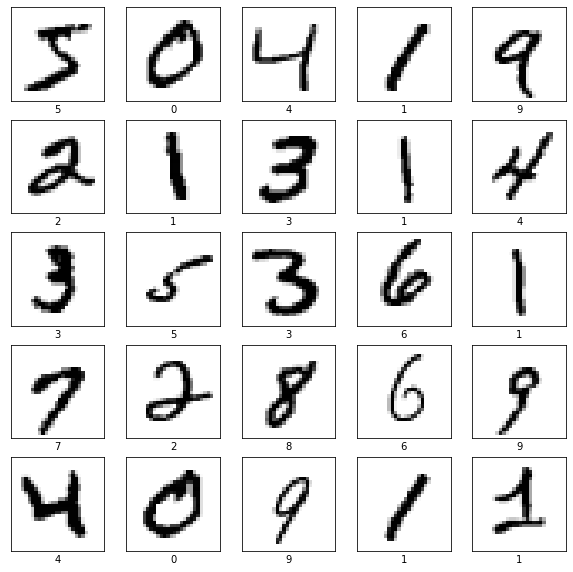

In [6]:
print_dataset_examples('mnist')

In [7]:
batch_size = 128
num_classes = 10
epochs = 32
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train, x_test, y_test = prepare_data(x_train, y_train, x_test, y_test)

model = run_convolutional_NN(x_train, y_train, x_test, y_test, num_classes, batch_size, epochs, input_shape)

Test loss: 0.3568229675292969
Test accuracy: 0.9023000001907349


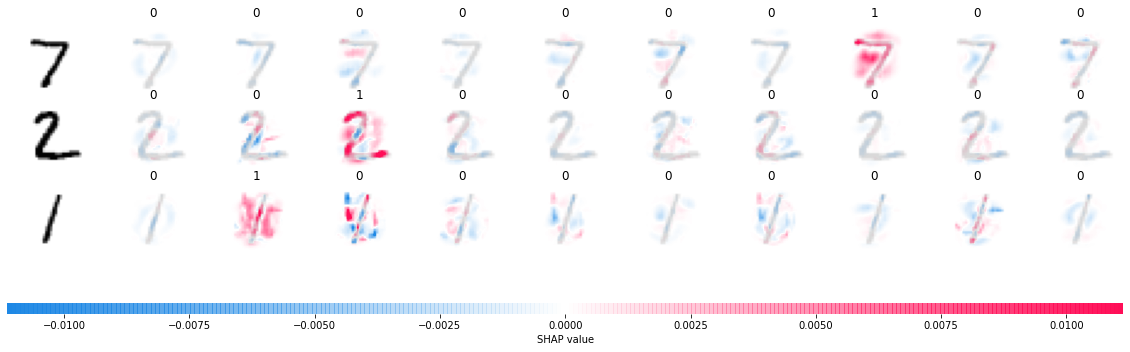

In [8]:
plot_DeepSHAP(model, x_train, y_train, x_test, y_test, 2000, 0, 3)

### Key points to interpret these plots:
- **Input images** are displayed on the first column of the left and as nearly transparent grayscale backings behind each of the explanations;
- The **interpretations** for every class is on the right;
- Anything colored in **red** increases the model output (the model is more confident in the classification);
- Everything colored **blue** decreases it (the model is less confident in the classification).

**The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output.**

## **Fashion-MNIST Dataset (Zalando's article)**

4423680/4422102 [==============================] - 0s 0us/step


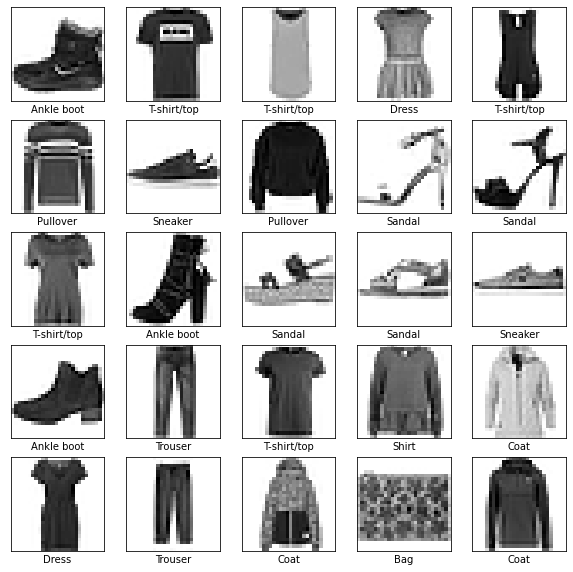

In [9]:
print_dataset_examples('fashion_mnist')

In [10]:
(x_train_1, y_train_1), (x_test_1, y_test_1) = fashion_mnist.load_data()
x_train_1, y_train_1, x_test_1, y_test_1 = prepare_data(x_train_1, y_train_1, x_test_1, y_test_1)
model_1 = run_convolutional_NN(x_train_1, y_train_1, x_test_1, y_test_1, num_classes, batch_size, epochs, input_shape)

Test loss: 0.7097070813179016
Test accuracy: 0.7488999962806702


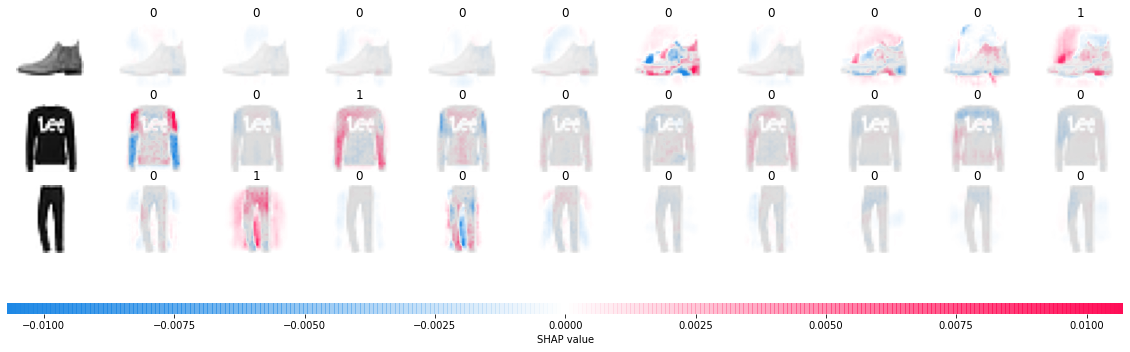

In [11]:
plot_DeepSHAP(model_1, x_train_1, y_train_1, x_test_1, y_test_1, 2000, 0, 3)

## **Natural language example - Sentiment analysis (transformers)**



In [13]:
# load a transformers pipeline model
model_3 = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model_3) 
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

# **END**